In [1]:
"""author: Vetivert? 💐 
created: 13/05/2025 @ 02:27:32"""

'author: Vetivert? 💐 \ncreated: 13/05/2025 @ 02:27:32'

# LOAD DATA

In [1]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib as mpl # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV # type: ignore
from sklearn.preprocessing import StandardScaler, label_binarize # type: ignore
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, f1_score, 
                             mean_squared_error, r2_score, roc_auc_score, make_scorer) # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from scipy.stats import randint, uniform # type: ignore
from mpl_toolkits.axes_grid1 import make_axes_locatable

import xgboost as xgb

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.prefix_path import *
# from src.utils.models import *
from src.utils.functions import *

In [15]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True)

df.reset_index(drop=True, inplace=True) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df = df.replace('8(nặng xin về)', 8)

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

# df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))
df['Diagnosis'] = np.where(df['Diagnosis'] == '3', '2', df['Diagnosis'])
df['Day of illness'] = np.where(df['Day of illness'] == '55', '5', df['Day of illness'])
df['Systolic BP'] = np.where(df['Systolic BP'] == 1120, 120, df['Systolic BP'])


# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)
# Get the integer position of the first hematoma column
hematoma_idx = df.columns.get_indexer([HEMATOMA_COLS[0]])[0]
#hematoma_idx.item() -> extract the value from np.int64 into native Python int
df.insert(hematoma_idx.item(), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)
# Get the integer position of the first bleeding column
bleeding_idx = df.columns.get_indexer([BLEEDING_COLS[0]])[0]
df.insert(bleeding_idx.item(), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)
# Get the integer position of the first additional diseases column
additional_diseases_idx = df.columns.get_indexer([ADDITIONAL_DISEASES[0]])[0]
df.insert(additional_diseases_idx.item(), 'additional_diseases', add_diseases['stacked_int'])
# df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': 56.4, '2': 39.66, '3': 3.94}


# FUNCTIONS

In [ ]:
def get_feature_importance(model, importance_type='gain'):
    """
    Get feature importance.
    
    Args:
        importance_type: 'gain', 'weight', 'cover', 'total_gain', 'total_cover'
        
    Returns:
        DataFrame with feature importances
    """
    
    # Get feature importance
    importance = model.get_booster().get_score(importance_type=importance_type)
    
    # Convert to DataFrame
    importance_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'Importance': list(importance.values())
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    return importance_df
    
def plot_feature_importance(model, x_features, top_n=10, importance_type='gain'):
    """
    Plot feature importance.
    
    Args:
        top_n: Number of top features to show
        importance_type: Type of importance metric
    """

    importance_df = model.get_booster().get_score(importance_type=importance_type)
    
    mapped_importances = {x_features[int(k[1:])]: v for k, v in importance_df.items()}

    mapped_importances_df = pd.DataFrame({
        'Feature': list(mapped_importances.keys()),
        'Importance': list(mapped_importances.values())
    }).sort_values(by='Importance', ascending=False)


    sns.barplot(x='Importance', y='Feature', data=mapped_importances_df.head(top_n))
    plt.title("Top 10 Important Features (XGBoost)")
    plt.axvline(x=np.mean(mapped_importances_df['Importance']).item(), color='red', linestyle='--')
    plt.tight_layout()
    plt.show()

    return mapped_importances_df
    
def evaluate(model, X, y_true, model_type='classifier'):
    """
    Evaluate model performance.
    
    Args:
        X: Features
        y_true: True target values
        
    Returns:
        Dict of evaluation metrics
    """
    y_pred_proba = model.predict(X)
    y_pred = [1 if float(p) >= 0.5 else 0 for p in y_pred_proba]
    y_true = [1 if float(p) >= 0.5 else 0 for p in y_true]
    # super().evaluate(X, y_true)  # Call the base class evaluate method
    
    if model_type == 'classifier':
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'f1_score': f1_score(y_true, y_pred, average='weighted', zero_division=0)
        }
        # Add ROC AUC for binary classification
        if len(np.unique(y_true)) == 2:
            try:
                y_prob = model.predict_proba(X)[:, 1]
                metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
            except:
                pass
    else:
        metrics = {
            'mse': mean_squared_error(y_true, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'r2': r2_score(y_true, y_pred)
        }
    
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report_dict).transpose()
    df_report.rename(index={'0': 'non dangerous', '1': 'dangerous'}, inplace=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_report.iloc[:3, :3], annot=True, cmap='Blues', fmt=".2f")  # Only show precision, recall, f1-score
    plt.title('Classification Report')
    plt.ylabel('Class')
    plt.xlabel('Metric')
    plt.tight_layout()
    plt.show()

    return metrics

# XGBOOST

In [75]:
feats = ['Bleeding',
        # 'Pulse rate',
        'Duration fever',
        'Day of illness',
        # 'Systolic BP',
        'Gende',
        # 'Diastolic BP',
        'Fatigue',
        # 'Mucosa membrane bleeding',
        'Vomiting',
        'Level of temp',
        'hematoma',
        'additional_diseases',
        'Liver enlargement',
        'Body ache',
        ]

In [125]:
df_set = df[feats].copy().fillna(0)

x1_train, x1_test, y1_train, y1_test = train_test_split(df_set, df['Diagnosis'], \
                                                    test_size=0.2, random_state=17, stratify=df['Diagnosis'])
x1_features = x1_train.columns

# x1_train, x1_test, y1_train, y1_test = x1_train.to_numpy(), x1_test.to_numpy(), y1_train.to_numpy(), y1_test.to_numpy()

print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

x1_train shape:  (324, 11) y1_train shape:  (324,)
x1_test shape:  (82, 11) y1_test shape:  (82,)
percentage of classes:  {'1': 56.1, '2': 43.9}


In [130]:
# y1_train.isna().sum()
y1_train


20     1
13     1
81     2
363    1
401    2
      ..
212    2
203    2
134    1
388    1
256    1
Name: Diagnosis, Length: 324, dtype: object

In [134]:
x1_train_np = x1_train.to_numpy().astype(int)
y1_train_np = y1_train.to_numpy().astype(int)
x1_test_np = x1_test.to_numpy().astype(int)
y1_test_np = y1_test.to_numpy().astype(int)

for i in range(len(y1_train_np)):
    if y1_train_np[i] == 1:
        y1_train_np[i] = 0
    elif y1_train_np[i] == 2:
        y1_train_np[i] = 1  

for i in range(len(y1_test_np)):
    if y1_test_np[i] == 1:
        y1_test_np[i] = 0
    elif y1_test_np[i] == 2:
        y1_test_np[i] = 1  

In [153]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    # use_label_encoder=False,
    eval_metric='error'
)

xgb_model.fit(x1_train_np, y1_train_np)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

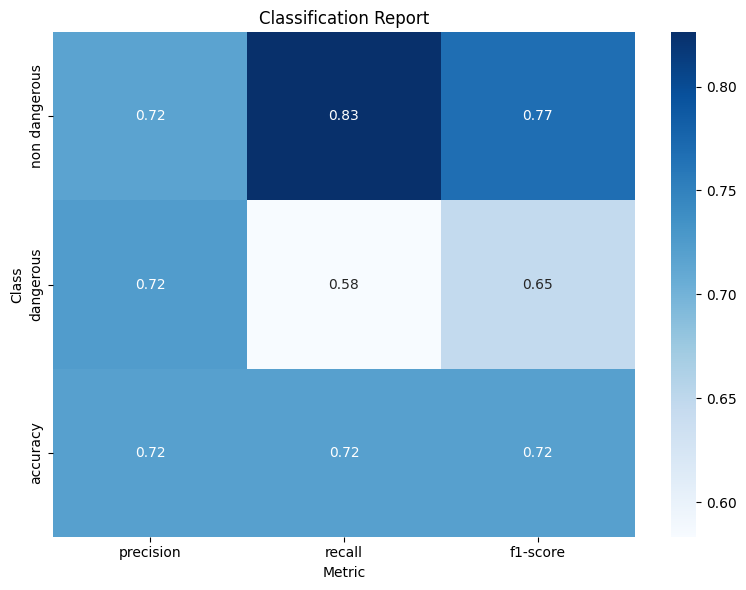

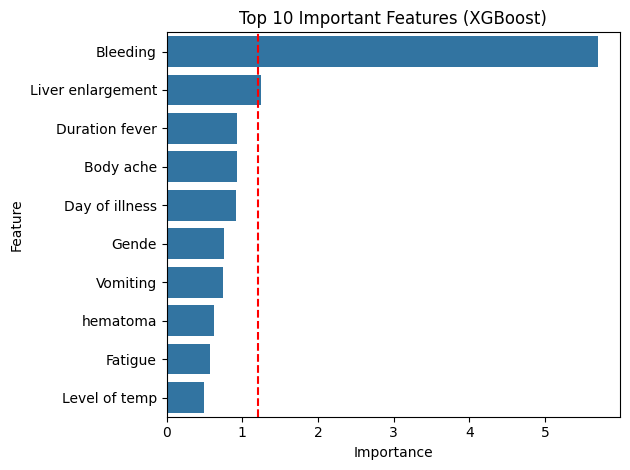

In [156]:
evaluate(xgb_model, x1_test_np, y1_test_np)
gain_importances_df = plot_feature_importance(xgb_model, x1_features)

In [80]:
gain_importances_df

,Feature,Importance
0,Bleeding,5.705929
9,Liver enlargement,1.246774
1,Duration fever,0.933445
10,Body ache,0.932129
2,Day of illness,0.918666
3,Gende,0.751349
5,Vomiting,0.750682
7,hematoma,0.630716
4,Fatigue,0.571537
6,Level of temp,0.498324


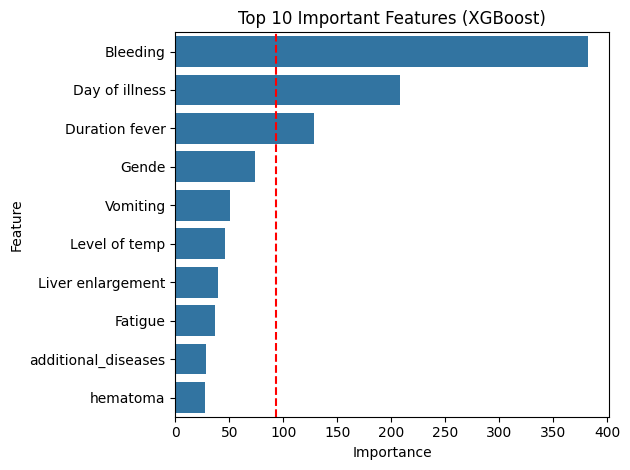

In [81]:
total_gain_importances_df = plot_feature_importance(xgb_model, x1_features, importance_type='total_gain')

In [82]:
total_gain_importances_df


,Feature,Importance
0,Bleeding,382.297241
2,Day of illness,208.537262
1,Duration fever,128.815353
3,Gende,73.632172
5,Vomiting,51.046345
6,Level of temp,45.845768
9,Liver enlargement,39.896759
4,Fatigue,36.578342
8,additional_diseases,28.395376
7,hematoma,27.120790


In [83]:
print(list(total_gain_importances_df['Feature']))
print(len(list(total_gain_importances_df['Feature'])))

['Bleeding', 'Day of illness', 'Duration fever', 'Gende', 'Vomiting', 'Level of temp', 'Liver enlargement', 'Fatigue', 'additional_diseases', 'hematoma', 'Body ache']
11


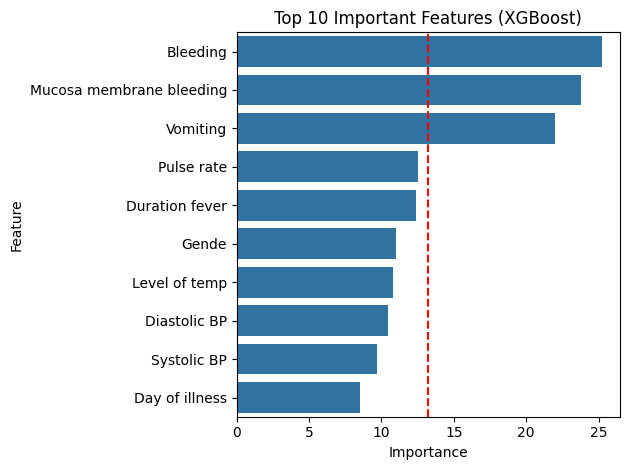

,Feature,Importance
2,Bleeding,25.220501
10,Mucosa membrane bleeding,23.766918
11,Vomiting,22.019567
6,Pulse rate,12.526509
5,Duration fever,12.399955
0,Gende,11.018052
4,Level of temp,10.762012
8,Diastolic BP,10.418636
7,Systolic BP,9.678736
3,Day of illness,8.483253


In [43]:
cover_importances_df = plot_feature_importance(xgb_model, x1_features, importance_type='cover')
cover_importances_df

In [69]:
print(x1_features, len(x1_features))

Index(['Bleeding', 'Duration fever', 'Day of illness', 'Gende', 'Fatigue',
       'Mucosa membrane bleeding', 'Vomiting', 'Level of temp', 'hematoma',
       'additional_diseases', 'Liver enlargement', 'Body ache'],
      dtype='object') 12


In [92]:
def distribution_plot(df_x, x_name: str):
    plt.subplots(figsize=(10, 6))
    x_0 = df_x.loc[df_x['Feature'] == 'f6', x_name]
    x_1 = df_x.loc[df_x['Feature'] == 'f1', x_name]
    x_2 = df_x.loc[df_x['Feature'] == 'f2', x_name]
    y_0 = np.random.rand(x_0.shape[0])
    y_1 = np.random.rand(x_1.shape[0])
    y_2 = np.random.rand(x_2.shape[0])

    plt.scatter(x_0, [4/80] * (y_0 + 1), label = 'Level of temp', color='red', alpha=0.65)
    plt.scatter(x_1, [2/80] * (y_1 + 1), label = 'Duration fever',color='navy', alpha=0.65)
    plt.scatter(x_2, [1/80] * (y_2 + 1), label = 'Day of illness',color='green', alpha=0.65)
    # plt.vlines(np.max(x_0), 0, (4/80) * (y_0[np.argmax(x_0)]+1), label = f'{np.max(x_0)}: max value of Diagnosis 3', color='red', alpha=0.65, linestyle="--")
    # plt.vlines(np.min(x_0), 0, (4/80) * (y_0[np.argmin(x_0)]+1), label = f'{np.min(x_0)}: min value of Diagnosis 3', color='red', alpha=0.65, linestyle=":")
    # plt.vlines(np.max(x_1), 0, (2/80) * (y_1[np.argmax(x_1)]+1), label = f'{np.max(x_1)}: max value of Diagnosis 2', color='navy', alpha=0.65, linestyle="--")
    # plt.vlines(np.min(x_1), 0, (2/80) * (y_1[np.argmin(x_1)]+1), label = f'{np.min(x_1)}: min value of Diagnosis 2', color='navy', alpha=0.65, linestyle=":")
    # plt.vlines(np.max(x_2), 0, (1/80) * (y_2[np.argmax(x_2)]+1), label = f'{np.max(x_2)}: max value of Diagnosis 1', color='green', alpha=0.65, linestyle="--")
    # plt.vlines(np.min(x_2), 0, (1/80) * (y_2[np.argmin(x_2)]+1), label = f'{np.min(x_2)}: min value of Diagnosis 1', color='green', alpha=0.65, linestyle=":")
    plt.vlines(np.mean(x_0), 0, 0.5, label = f'{np.mean(x_0)}: mean value of Level of temp', color='red', alpha=0.65, linestyle="--")
    plt.vlines(np.mean(x_1), 0, 0.5, label = f'{np.mean(x_1)}: mean value of Duration fever', color='navy', alpha=0.65, linestyle="--")
    plt.vlines(np.mean(x_2), 0, 0.5, label = f'{np.mean(x_2)}: mean value of Day of illness', color='green', alpha=0.65, linestyle="--")
    
    sns.kdeplot(x_0, color='red')
    sns.kdeplot(x_1, color='navy')
    sns.kdeplot(x_2, color='green')
    plt.legend()
    # plt.xlim(-10, np.max(df_x[x_name]) + 100)
    plt.yticks([])
    plt.title(x_name + ' Distribution by Features', fontsize=14)
    # plt.colorbar(ticks = [1,2,3], values = [1,2,3], label='Diagnosis')

    # fig.colorbar(cmap=['green','navy','red'], ticks = [1,2,3], values = [1,2,3], ax = ax[0], label='Diagnosis')
    # fig.suptitle(x_name + ' Distribution by Diagnosis', fontsize=16)
    plt.show()

In [85]:
df_tree = xgb_model.get_booster().trees_to_dataframe()
print(df_tree[['Feature', 'Split', 'Node']].dropna())

     Feature  Split  Node
0         f0    1.0     0
1         f2    5.0     1
2         f4    1.0     2
3         f1    7.0     3
4         f9    1.0     4
...      ...    ...   ...
1911      f2    3.0     4
1913      f1    3.0     6
1914      f3    1.0     7
1917      f5    1.0    10
1919      f8    1.0    12

[913 rows x 3 columns]


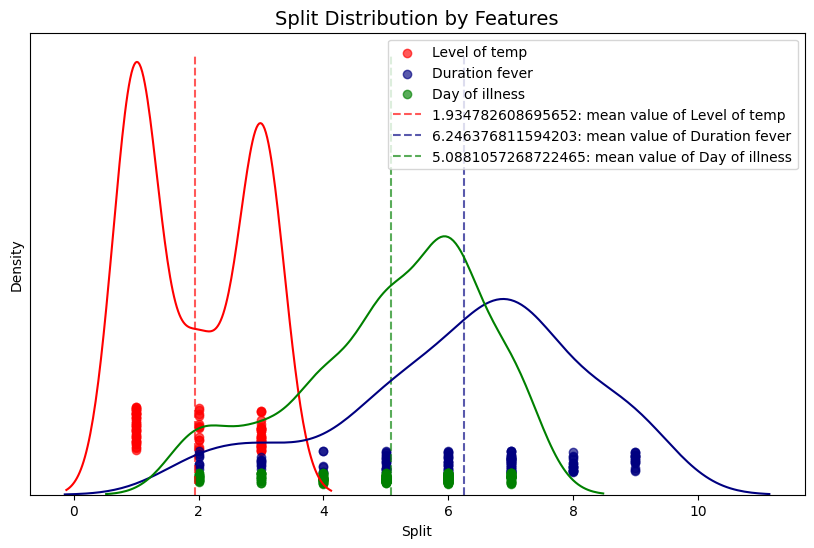

In [93]:
distribution_plot(df_tree, 'Split')

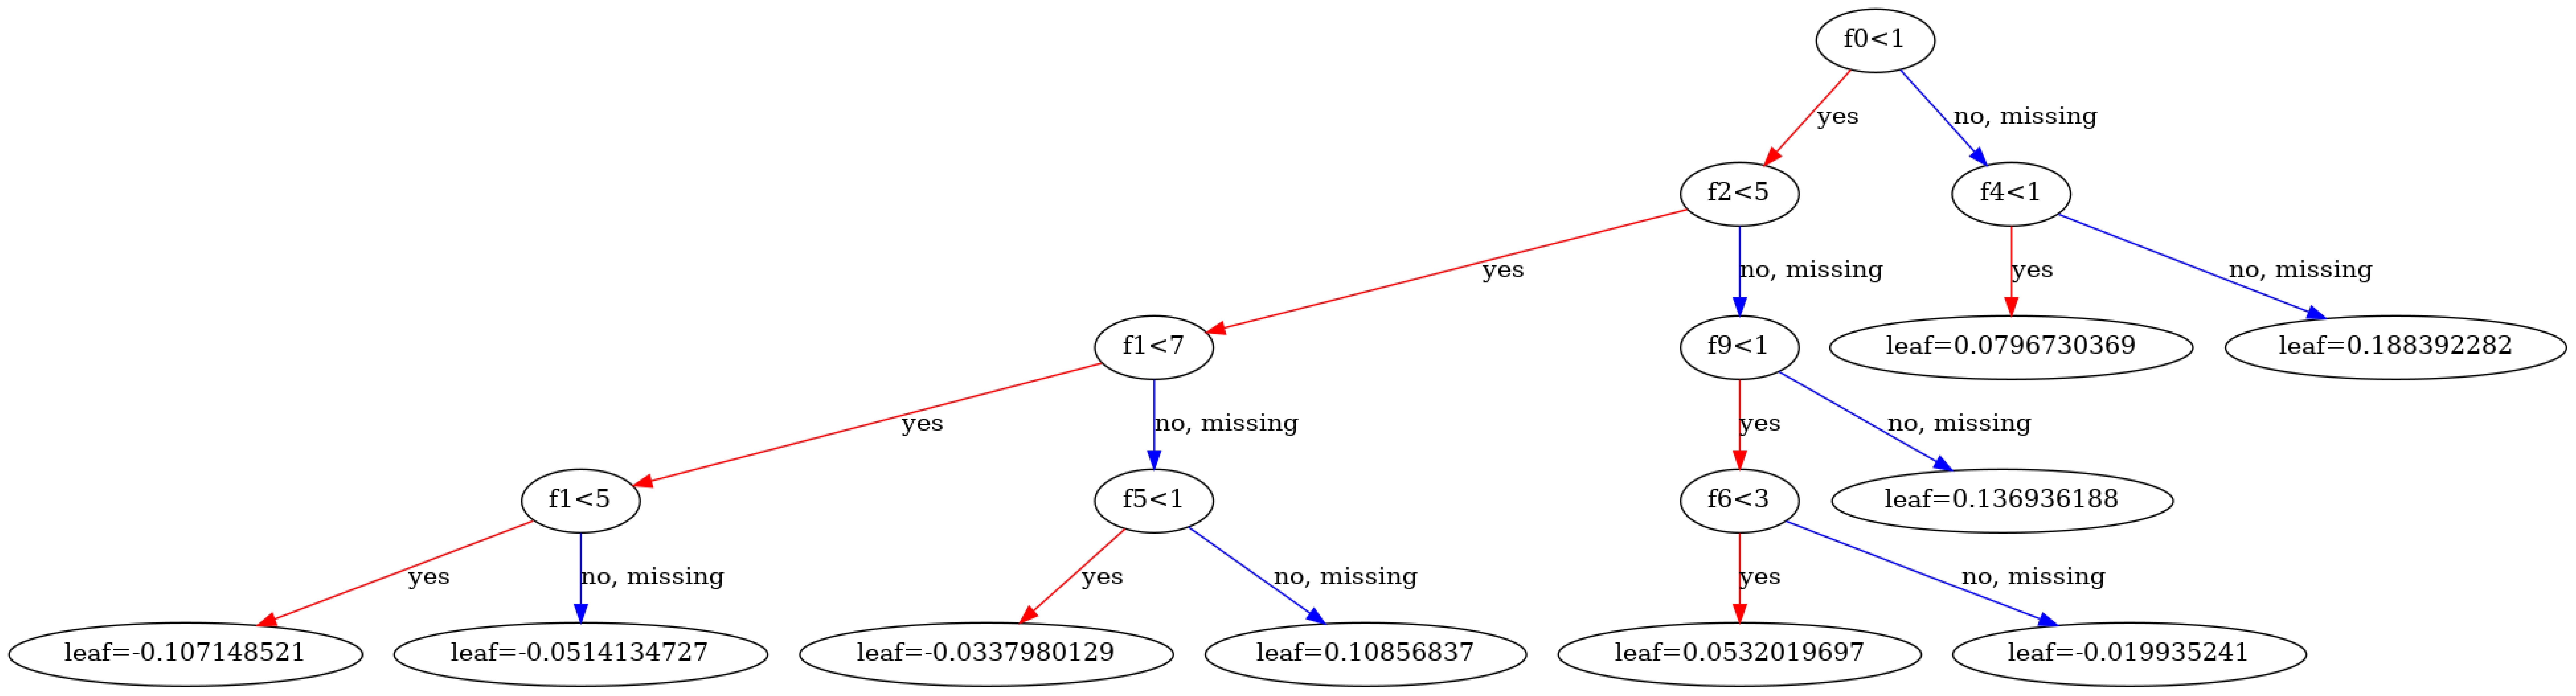

In [ ]:
# import graphviz

xgb.plot_tree(xgb_model, tree_idx=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)
# plt.savefig('tree.png')
plt.show()

In [117]:
def custom_accuracy(y_true, y_pred):
    # Convert inputs to binary if needed
    y_true_bin = (y_true > 0).astype(int)
    y_pred_bin = (y_pred > 0).astype(int)
    return accuracy_score(y_true_bin, y_pred_bin)

# Create a scorer
custom_scorer = make_scorer(custom_accuracy)

In [167]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.01, 0.1, 0.2]
}

# search = RandomizedSearchCV(xgb.XGBClassifier(), param_grid, cv=StratifiedKFold(n_splits=10), scoring='accuracy', verbose=1)
search = GridSearchCV(xgb_model, param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
search.fit(x1_train_np, y1_train_np)
print("Best parameters:", search.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


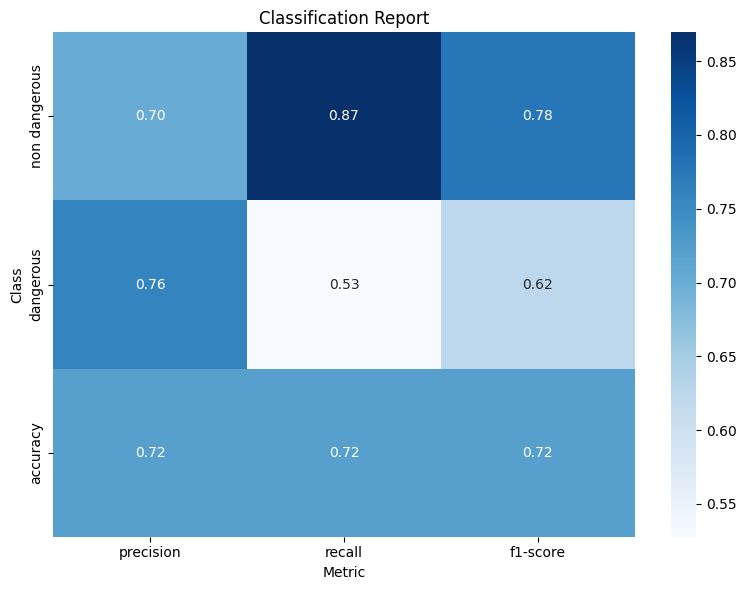

{'accuracy': 0.7195121951219512,
 'precision': 0.7273256311510483,
 'recall': 0.7195121951219512,
 'f1_score': 0.7091998152195433,
 'roc_auc': 0.7844202898550725}

In [168]:
xgb_grid = search.best_estimator_
evaluate(xgb_grid, x1_test_np, y1_test_np)

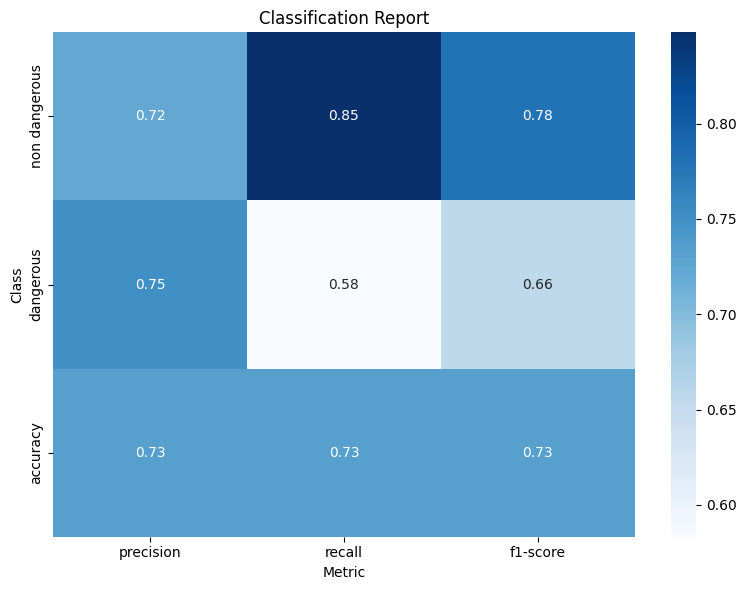

{'accuracy': 0.7317073170731707,
 'precision': 0.7344173441734417,
 'recall': 0.7317073170731707,
 'f1_score': 0.7256707317073171,
 'roc_auc': 0.8028381642512078}

In [164]:
xgb_search = search.best_estimator_
evaluate(xgb_search, x1_test_np, y1_test_np)

In [169]:
import joblib

joblib.dump(xgb_search, 'XGB.pkl')

['XGB.pkl']